### Getting and preprocessing the data
First we get the dataset online, then apply subsampling, then divide the dataset in equally long sentences

In [3]:
%%time
from collections import Counter
import numpy as np
from gensim.test.utils import datapath
import gensim.downloader as api
import random
from itertools import dropwhile

def sampling(dataset,threshold=1e-4, min_count=5):
    
    # Count occurences of each word in the dataset 
    word_counts = Counter(dataset)  
    total_count = len(dataset)
    
    freqs = {word: count/total_count for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
    train_words = [word for word in dataset if random.random() < (1 - p_drop[word]) and word_counts[word]>min_count]
    return train_words

"Transforms a list of words to a list of sentences with length=len_sen"
def words_to_sentences(words):
    new_ds = []
    len_sen = int(len(words)/1700)
    len_sen = 20
    for i in range(0, len(words), len_sen):
        y = [words[i:i + len_sen]]
        new_ds.extend(y)
    return new_ds
    

# Get dataset online
dataset = api.load('text8')
print('ntm')
# Convert to list of words
text8_ds = []
for x in dataset: 
    for y in x:
        text8_ds.append(y)
        
# Subsampling
text8_ds = sampling(text8_ds)

# New dataset with sentences of length=20
text8_dataset = words_to_sentences(text8_ds)

ntm
CPU times: user 19.8 s, sys: 751 ms, total: 20.5 s
Wall time: 20.7 s


### Evaluation methods

In [4]:
from scipy import stats, spatial 
import csv, numpy as np
from scipy.stats.stats import pearsonr
from scipy import spatial 
from sklearn.metrics.pairwise import cosine_similarity
#IMPORT DATA
def get_wordsim_data():
    wordsim_data = [] 
    with open('./data/wordsim/set1.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ',quotechar='|')
        for row in reader: 
            wordsim_data.append(row[0].split(',')[0:3])
    del wordsim_data[0]
    with open('./data/wordsim/set2.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ',quotechar='|')
        for i,row in enumerate(reader):
            if i!=0:
                wordsim_data.append(row[0].split(',')[0:3])

    wordsim_vocab = set()
    for x in wordsim_data:
        wordsim_vocab.add(x[0])
        wordsim_vocab.add(x[1])
    return wordsim_data

#len(wordsim_vocab.intersection(text8_dataset_first_sentence.vocab))
def wordsim_task(dict_emb):
    wordsim_data = get_wordsim_data()
    scores = []
    distances = []
    distances1 = []
    for task in wordsim_data: 
        if (task[0] in dict_emb.keys() ) and (task[1] in dict_emb.keys()):
            scores.append(float(task[2]))
            distances.append(10-(spatial.distance.cosine(dict_emb[task[0]], dict_emb[task[1]]))*10)
            
            
    #return stats.zscore(np.array([x[1] for x in out],dtype=float))
    return np.corrcoef(scores,distances),zip(scores,distances)

#print(wordsim_task(gensim_emb))
#wordsim_task(dict_emb)

In [5]:
import pickle
import torch
with open("/home/c3dric/model/Adagrad/dict_emb_OptimAdagrad_momentum0_nesterovFalse_step_size1_gamma1_shuffleFalse_batch_size2000_alpha0.25_dim100_workers1_ctxw5_neg_samples10_use_cudaTrue_iterations3.pkl", 'rb') as output:
        dict_emb = pickle.load(output)

In [6]:
x,y = wordsim_task(dict_emb)
list(x)

[array([1.        , 0.66890975]), array([0.66890975, 1.        ])]

### Model

In [12]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')
gpu = torch.device("cuda:0")


class SkipGramModel(nn.Module):

    def __init__(self, vocab_size, emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=False)
        self.v_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=False)
        self.init_emb()
        

    def init_emb(self):
        initrange = 0.5 / self.emb_dimension
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-1,1)
        
            
    def forward(self, pos_u, pos_v,neg_v):
        pos_u = pos_u.view(-1).to(device)
        pos_v = pos_v.to(device)
        neg_v = neg_v.to(device)
        emb_u = self.u_embeddings(pos_u)
        samples = torch.cat([pos_v,Variable(neg_v)],1)
        emb_v = self.v_embeddings(samples)
        score = torch.bmm(emb_v, emb_u.unsqueeze(2)).squeeze()
        score[:,1:]=score[:,1:].neg()
        score = F.logsigmoid(score)
        return -1 * (torch.sum(score))/ pos_u.size(0)

In [8]:
import torch 
x = torch.ones(5,2)
y = torch.sum(x)/x.size(0)
x,y

(tensor([[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]), tensor(2.))

In [9]:
from torch.utils.data import Dataset
from collections import defaultdict
import random

class wDataSet(Dataset):
    LEN_SEN =20
    def __init__(self, dataset, power=0.75,ctx_window=2,):
        assert( all(len(sentence)== LEN_SEN) for sentence in dataset)
        self.ctx_window = ctx_window
        self.dataset = dataset
        self.word2idx = dict()
        self.idx2word = dict()
        self.word_count = defaultdict(int)
        self.vocab_size = int()
        self.vocab = set()
        self.create_vocab()
        self.pairs = self.generate_pairs()
        self.key_pairs = self.generate_key_pairs(self.pairs)
        self.power = power        
        self.neg_table = self.make_neg_table(self.power)
        self.len = self.__len__()

        
    def generate_pairs(self):
        print("Generating pairs")
        pairs = []
        for sentence in self.dataset:
            for i,word in enumerate(sentence):
                for j in range(1,random.randint(2,self.ctx_window+1)):
                    if(i+j<len(sentence)):
                        pairs.append((word,sentence[i+j]))
                    if((i-j)>=0):
                        pairs.append((word,sentence[i-j]))

        return pairs
        
    def __len__(self):
        center_pairs = ((LEN_SEN - ctx_window*2)*ctx_window*2) 
        border_pairs = sum([ctx_window + i for i in range(ctx_window)])*2
        return center_pairs + border_pairs        
        
        
        
    def __getitem__(self, idx):
        id_sen = int(self.len/idx)
        return self.key_pairs
    
    def get_neg_samples(self, count, batch_size):
        return torch.tensor(np.random.choice(list(self.idx2word.keys()),size=(batch_size)*count,replace=True,p=self.neg_table)).view(batch_size,-1)
   
    """ Defines the probability of choosing a negative sampling, set empiraccaly by mikolov"""
    def make_neg_table(self, power):
        pow_frequency = np.array([self.word_count[self.idx2word[i]] for i in range(len(self.word_count))])**power
        return pow_frequency / pow_frequency.sum()
        

    def generate_key_pairs(self,pairs):
        print("Generating key_pairs")
        key_pairs = []
        for x,y in pairs:
            key_pairs.append((self.word2idx.get(x),self.word2idx.get(y)))
        print("finished creating key_pairs")
        return key_pairs
    
    """"Creating vocabulary and creating dictionary with a one to one mapping int to word"""
    def create_vocab(self):
        print("Creating vocab")
        for i,sentence in enumerate(self.dataset):
            for word in sentence:
                self.word_count[word] += 1
                self.vocab.add(word)
        self.word2idx = {w: idx for (idx, w) in enumerate(self.vocab)}
        self.idx2word = {idx: w for (idx, w) in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
        

In [17]:
import torch
import pickle
from torch.utils.data import DataLoader
import copy
import time
import numbers 
class W2V():
    def __init__(self, data,dim=100, neg_samples=10, alpha=0.4, iterations=20, batch_size=5000, 
                 shuffle=False,workers=1,momentum=0,nesterov=False,step_size=1,gamma=1,rho=0.9):
        #Param for sgd with momentum
        self.momentum = momentum
        self.nesterov = nesterov
        
        # Params for decayin the learning rate 
        self.step_size = step_size
        self.gamma = gamma
        
        # General training params
        self.shuffle = shuffle        
        self.batch_size = batch_size
        self.alpha = alpha
        self.dim = dim
        self.data = data
        self.workers = workers
        self.ctxw = self.data.ctx_window
        self.neg_samples = neg_samples
        self.models = []
        self.optimizers = []
        self.loss_list = []
        self.model = SkipGramModel(len(self.data.vocab), self.dim)
        self.model.to(device)
        # Param needed for adadelta 
        self.rho = rho 
        print(device)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=alpha, momentum=momentum,nesterov=nesterov)
       # self.optimizer = torch.optim.Adadelta(self.model.parameters(),rho=self.rho)
        #self.scheduler = StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        self.optimizer = torch.optim.Adagrad(self.model.parameters(), lr=alpha)

        self.iterations = iterations
 
    def train_with_loader(self,save_embedding=True):
        loader = DataLoader(self.data.key_pairs, self.batch_size, self.shuffle, num_workers=self.workers)
        print('starting training')
        tenth = int(len(loader)/10)
        no_improvement = 0
        for epoch in range(self.iterations):

            percent = 0
            start = time.time()
            processed_batches = 0 
            pairs = 0
            cum_loss = 0 
            avg_loss =0
            best_loss = 10 
            
            for i,(pos_u,pos_v) in enumerate(loader):
                if(i%tenth == 0 ):
                    end = time.time()
                    hours, rem = divmod(end-start, 3600)
                    minutes, seconds = divmod(rem, 60)
                    time_since_start = "Time:  {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
                    if(processed_batches!=0):
                        avg_loss = cum_loss / processed_batches
                    print("0%" + "=" *(int(percent/10))+ str(percent) +"%, " + time_since_start + ", avg_loss = {}".format(avg_loss),end="\r" )
                    percent+=10
                    
                neg_v = self.data.get_neg_samples(self.neg_samples,pos_v.size()[0])
                pos_v = pos_v.view(len(neg_v),-1)
                self.optimizer.zero_grad()
                loss = self.model.forward(pos_u,pos_v,neg_v)
                cum_loss += loss
                loss.backward()
                self.optimizer.step()
                pairs += len(pos_u)
                processed_batches += 1
                
            print("\n{0:d} epoch of {1:d}".format(epoch+1, self.iterations))
            avg_loss = cum_loss / processed_batches
            print(" {0:d} {1:d} batches, pairs {2:d}, avg loss: {3:.5f}".format(i,processed_batches, pairs,avg_loss))
            self.loss_list.append(avg_loss)
            self.time = time_since_start
            self.model = self.model.to(cpu)
            print("Current score on wordsim Task: {}".format(wordsim_task(self.get_embedding())[0][1]))
            self.model = self.model.to(device)
        
            if(avg_loss<best_loss):
                best_loss = avg_loss
            else:
                no_improvement +=1
        
            if(no_improvement > 3):
                self.iterations = epoch
                break
            
        if(save_embedding):
            self.save_embedding()
            

    def get_embedding(self):
        embedding_dict = dict()
        embedding = self.model.u_embeddings.weight.data.numpy()
        for i in range(len(self.data.idx2word)):
            embedding_dict[self.data.idx2word[i]]= embedding[i]
        return embedding_dict
    
    def save_embedding(self, with_loss=True):
        print('ntm')
        # Creating filename
        optim = "Optim" + str(self.optimizer).split(" ")[0] + "_"
        filename = "dict_emb_" +  optim + "_".join([x + str(y) for x,y in vars(self).items() if isinstance(y, numbers.Number)]) + ".pkl"
        
        # Getting Embedding
        self.model.to(torch.device('cpu'))
        dict_emb = w2v.get_embedding()
        
        # Adding loss history to embedding
        dict_emb['loss_list'] = [x.to(torch.device('cpu')) for x in self.loss_list]
        
        # Evaluating the model on the word similarity task, saving the score to the embedding 
        dict_emb['ws_score'] = wordsim_task(dict_emb)[0][1]
        
        # Saving time spent to calculate 1 epoch
        dict_emb['time'] = self.time
        
        # Logging
        print("Saving embedding: {} to disk with ws_score: {} ".format(filename,dict_emb['ws_score']))
    
        # Writing embedding dictionnary to disk
        with open(filename, 'wb') as output:
            pickle.dump(dict_emb, output, pickle.HIGHEST_PROTOCOL)
        
        self.model.to(device)
        self.loss_list = [x.to(device) for x in self.loss_list]
    
 

            

In [18]:
text8_dataset_first_sentence = wDataSet((text8_dataset[0:100]),ctx_window=2)
w2v = W2V(text8_dataset_first_sentence, batch_size=10,iterations=3,alpha=10)
w2v.train_with_loader()

Creating vocab
Generating pairs
Generating key_pairs
finished creating key_pairs
cpu
starting training
0%==========100%, Time:  00:00:05.13, avg_loss = 1949.69531258125
1 epoch of 3
 544 545 batches, pairs 5449, avg loss: 1953.19678
Current score on wordsim Task: [0.78478594 1.        ]


KeyboardInterrupt: 

In [111]:
LEN_SEN =20
def get_len(ctx_window):
    number_pairs = ((LEN_SEN - ctx_window*2)*ctx_window*2) 
    #print(number_pairs)
    #print([ctx_window + i for i in range(ctx_window)])
    start_pairs = sum([ctx_window + i for i in range(ctx_window)])*2
    #print(len([ctx_window + i for i in range(ctx_window)]))
    #print(start_pairs)
    return start_pairs + number_pairs
print(get_len(5))
n_pairs_in_sen = get_len(5)
n_pairs = 10* get_len(5)
list_of_sen = [i for i in range(1700)]
list_of_sen = [list_of_sen[i:i + 170] for i in range(0, len(list_of_sen), 170)]
dataset = [[x for x in range(20)] for i in range(10)]
ctx_window = 5
def get_item(idx):
        start_pairs = sum([ctx_window + i for i in range(ctx_window)])
        number_pairs = ((LEN_SEN - ctx_window*2)*ctx_window*2)
        print(start_pairs)
        id_sen = int(idx/n_pairs_in_sen)
        sen  = list_of_sen[id_sen]
        print("sentence number =" + str(id_sen))
        pair_id_in_sen = idx - id_sen*(start_pairs*2 + number_pairs)
        if(pair_id_in_sen <= start_pairs):
            return -1
        elif(pair_id_in_sen >= start_pairs + number_pairs):
            return 1
        else:
            return 0
            

#print(list_of_sen)
get_item(206)
print(list_of_sen)

170
35
sentence number =1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169], [170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

In [30]:
w2v.train_with_loader()

starting training
> <ipython-input-28-cb5b77309c61>(39)forward()
-> return -1 * (torch.sum(score))/ pos_u.size(0)
(Pdb) emb_u.unsqueeze(2)
tensor([[[ 2.7795e-03],
         [ 3.8988e-03],
         [-4.8614e-03],
         [-4.2876e-03],
         [-3.9053e-03],
         [-3.7474e-03],
         [-2.5727e-03],
         [ 1.4524e-03],
         [ 1.8151e-03],
         [-1.6951e-03],
         [ 4.2642e-04],
         [ 4.9185e-03],
         [ 4.6678e-04],
         [-2.6394e-03],
         [ 1.3716e-03],
         [ 2.9871e-03],
         [ 4.3334e-03],
         [ 2.5287e-03],
         [-2.1342e-03],
         [ 3.7585e-03],
         [ 1.4491e-03],
         [-1.4925e-03],
         [ 3.1388e-03],
         [-3.0012e-03],
         [-1.8019e-03],
         [ 1.4885e-04],
         [ 3.5942e-03],
         [-2.3165e-03],
         [-1.0843e-03],
         [-1.7156e-03],
         [-2.3725e-03],
         [-2.7886e-04],
         [ 4.8063e-03],
         [-8.1922e-04],
         [-2.7201e-04],
         [ 3.0028e-03

BdbQuit: 

In [88]:
text8_wDataset = wDataSet((text8_dataset),ctx_window=5)

cpu


In [89]:
l_rho = [0.9,0.85,0.8,0.95]
for rho in l_rho:
    w2v = W2V(text8_wDataset, rho=rho)
    w2v.train_with_loader()

starting training
0%==========100% Time:  00:00:03.29
1 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.08
0%==========100% Time:  00:00:02.86
2 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.07
0%==========100% Time:  00:00:03.11
3 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.07
0%==========100% Time:  00:00:02.92
4 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.06
0%==========100% Time:  00:00:03.81
5 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.06
0%==========100% Time:  00:00:03.47
6 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.06
0%==========100% Time:  00:00:02.98
7 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.05
0%==========100% Time:  00:00:03.42
8 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.05


KeyboardInterrupt: 

### EVALUATION

In [32]:
import pickle
import torch
with open("dict_emb_w2vbs7000_neg7_dim100_epochs20_ctxw10_alpha0-075decayhalf.pkl", 'rb') as output:
        dict_emb = pickle.load(output)

ImportError: No module named 'torch'

In [57]:
from scipy import spatial

x = spatial.distance.cosine(gensim_emb['love'], gensim_emb['music'])
y = spatial.distance.cosine(gensim_emb['anarchism'],gensim_emb['music'])
z = spatial.distance.cosine(gensim_emb['revolution'],gensim_emb['creatine'])

l = ['music','anarchism','revolution','philosophy','creatine']
print(x)
print(y)
z

0.30364346504211426
0.45958149433135986


0.5577877461910248

In [10]:
dict_emb.pop('loss_list')

[tensor(5.5450, requires_grad=True),
 tensor(5.5439, requires_grad=True),
 tensor(5.5429, requires_grad=True),
 tensor(5.5426, requires_grad=True),
 tensor(5.5412, requires_grad=True),
 tensor(5.5425, requires_grad=True),
 tensor(5.5414, requires_grad=True),
 tensor(5.5402, requires_grad=True),
 tensor(5.5409, requires_grad=True),
 tensor(5.5391, requires_grad=True),
 tensor(5.5376, requires_grad=True),
 tensor(5.5360, requires_grad=True),
 tensor(5.5368, requires_grad=True),
 tensor(5.5365, requires_grad=True),
 tensor(5.5357, requires_grad=True),
 tensor(5.5351, requires_grad=True),
 tensor(5.5354, requires_grad=True),
 tensor(5.5333, requires_grad=True),
 tensor(5.5336, requires_grad=True)]

In [59]:
gensim_emb = dict()
for sentences in text8_dataset:
    for word in sentences:
        gensim_emb[word] = model.wv[word]

In [1]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec


class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.cum_loss = 0
        self.processed_batches = 0


    def on_epoch_end(self, model):
        avg_loss = self.cum_loss/self.processed_batches
        print("Epoch #{} end: avg_loss={}".format(self.epoch,avg_loss))
        self.epoch += 1
    
    def on_batch_end(self, model):
        """Method called at the end of each batch.
        Parameters
        ----------
        model : :class:`~gensim.models.base_any2vec.BaseWordEmbeddingsModel`
            Current model.
        """
        self.cum_loss += model.get_latest_training_loss()
        self.processed_batches +=1
        


In [23]:
def get_distances(word):
    for x in dict_emb.keys():
        yield(x, spatial.distance.cosine(dict_emb[word],dict_emb[x]))

In [54]:
n_dict_emb = {(word): (x / np.linalg.norm(x)) for (word, x) in (dict_emb.items())}
n_dict_emb_gensim = {(word): (x / np.linalg.norm(x)) for (word, x) in (gensim_emb.items())}

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

### ANALOGY TASK

In [ ]:
file = open("./data/questions-words.txt")
questions = file.readlines()
qeustions_vocab = set()
for i,x in enumerate(questions): 
    questions[i] = x.rstrip("\n").split()
    if x[0]==':':
        del questions[i]
    else: 
        for word in x:
            questions_vocab.add(y)



In [2]:
def read_in_chunks(file_object, chunk_size=1024):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data


In [3]:
file = open("./data/enwik9")
enwik9 = read_in_chunks(file)
l = []
for x in enwik9:
    l.append(x)



In [ ]:
#TODO: logging, save loss, batch_size
epoch_logger = EpochLogger()
model = Word2Vec(l, size=100,window=5,negative=10, alpha=0.01, min_count=5, workers=4,sg=1, callbacks=[epoch_logger],compute_loss=True)


In [19]:
def analogy_task(questions,dict_emb):
    score = []
    if all(word in dict_emb for word in questions):
        y = dict_emb[questions[0]] -  dict_emb[questions[1]] +  dict_emb[questions[2]]
        x = get_closest_with_score(dict_emb,y)
        if x == questions[3]:
            score.append(1)
        else: 
            score.append(0)
    return score
        

In [31]:
import numpy as np
# TODO: calculate closest only for a given set of words to get faster computation for analogy task
def calculate_sim(dict_emb): 
    # Create dictionnary with id for every word, this is needed because sometimes we only have access to the dict_emb
    # and not the whole model 
    idx2word = {idx: w for (idx, w) in enumerate(dict_emb.keys())}
    word2idx = {w: idx for (idx, w) in enumerate(dict_emb.keys())}
    
    emb_size = len(next(iter(dict_emb.values())))
    
    # Create an embedding dictionnary with normalized vectors
    normalized_dict_emb = {(word): (x / np.linalg.norm(x)) for (word, x) in (dict_emb.items())}
    
    # Create an vocab_size*emb_size Matrix that holds the normalized embeding of each word in it's row called matrix_row
    # Create an emb_size*vocab_size Matrix that holds the normalized embeding of each word in it's colomn  matrix_colomn
    for i in range(0,len(dict_emb.keys())):
        y = normalized_dict_emb[idx2word[i]]
        if i ==0:
            matrix_colomn = torch.tensor(y).view(emb_size,1)
            matrix_row = torch.tensor(y)
        else:
            matrix_colomn = torch.cat([matrix_colomn,torch.tensor(y).view(emb_size,1)],1)
            matrix_row = torch.cat([matrix_row,torch.tensor(y)])
    
    matrix_row = matrix_row.view(-1,emb_size)
    
    matrix_row = matrix_row.to(device)
    matrix_colomn = matrix_colomn.to(device)
    
    return 1-(torch.matmul(matrix_row,matrix_colomn)),word2idx






    

In [221]:
import random
def get_closest(score_dict, word):
    closest = ()
    distance = 3
    for (x,y),score in score_dict.items():
        #print(x,y,score)
        if((x != y) and ((x==word)or(y==word))):
            if (distance > score):
                closest = (x,y)
                distance = score
    return closest

def get_closest_with_score(dict_emb,y):
    distance = 100
    for x,emb in dict_emb.items():
        if(spatial.distance.cosine(dict_emb[x], dict_emb[y])<distance):
            closest = x
    return x
        

### Visualization of the Data

In [1]:
import os
list_of_files = []
for file in os.listdir("/home/c3dric/model/todo"):
        list_of_files.append(file)


In [2]:
list_of_files.remove('.ipynb_checkpoints')

In [3]:
import pickle
file_emb = []
for file in list_of_files:
    with open("/home/c3dric/model/todo/" + file, 'rb') as output:
        dict_emb = pickle.load(output)
    file_emb.append((file, [float(x) for x in dict_emb['ws_list']]))

In [137]:
file_emb[3]

IndexError: list index out of range

In [5]:
import re
import csv
with_0 = r'(\w*)alpha(\d.\d*)_\w*'
without_0 = r'(\w*)alpha(\d)_\w*'
sgd_reg = r'(\w*)momentum0_.*'
models_sgd = []
models_adam = []
models_adagrad = []
models_mom = []
models_nag = []
for model in file_emb:
    filename = model[0] 
    if "OptimAdagrad" in filename: 
        models_adagrad.append(model)
    if "OptimAdam" in filename: 
        models_adam.append(model)
    if "OptimSGD" in filename:
        if(re.search(sgd_reg,filename)):
            models_sgd.append(model)
        elif("nesterovFalse" in filename):
            models_mom.append(model)
        else:
            models_nag.append(model)
        
assert(len(file_emb) == len(models_sgd + models_adam + models_adagrad + models_mom + models_nag))
len(models_sgd + models_adam + models_adagrad + models_mom + models_nag)

def create_csv(models,csv_file_name):
    lr = []
    lr_scores = []
    epochs = [[] for x in range(20)]
    for model in models:
        filename = model[0]
        if(re.search (without_0,filename)):
            alpha =  int(re.search(without_0,filename).group(2))
            lr_scores.append((alpha,model[1]))
        if(re.search (with_0,filename)):
            alpha =  float(re.search(with_0,filename).group(2))
            lr_scores.append((alpha,model[1]))
    lr_scores = sorted(lr_scores)
    lr = [x[0] for x in lr_scores]
    scores = [x[1] for  x in lr_scores]
    
    for x in lr_scores: 
        ws_scores = x[1]
        for i,score in enumerate(ws_scores):
            epochs[i].append(score)
        for j in range(i+1,20):
            epochs[j].append("")
            
    
    output = [lr] + epochs 
    
    with open(csv_file_name, 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(output)
        csvFile.close()


create_csv(models_adam,"adam.csv")
create_csv(models_adagrad,"adagrad.csv")
create_csv(models_sgd,"sgd.csv")
create_csv(models_mom,"mom.csv")
create_csv(models_nag,"nag.csv")


In [60]:
list_example_conv = file_emb[0][1]

In [23]:
with open("/home/c3dric/model/Adagrad/dict_emb_OptimAdagrad_momentum0_nesterovFalse_step_size1_gamma1_shuffleFalse_batch_size5000_alpha0.25_dim100_workers1_ctxw5_neg_samples10_use_cudaTrue_iterations20.pkl", 'rb') as output:
    dict_emb = pickle.load(output)

In [12]:
## Taken from https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/word2vec.ipynb##
import logging
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

def reduce_dimensions(model,vocab, vocab_plot, plot_in_notebook = True):

    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = []        # positions in vector space
    labels = []         # keep track of words to label our data again later
    for word in vocab:
        vectors.append(model[word])
        labels.append(word)
        
    
    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)
    
    # reduce using t-SNE
    vectors = np.asarray(vectors)
    logging.info('starting tSNE dimensionality reduction. This may take some time.')
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    
    x_vals = [v[0] for i,v in enumerate(vectors) if labels[i] in vocab_plot]
    y_vals = [v[1] for i,v in enumerate(vectors) if labels[i] in vocab_plot]
        
    # Create a trace
    trace = go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='text',
        text=labels
        )
    
    data = [trace]
    
    logging.info('All done. Plotting.')
    
    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')



In [ ]:
money_vocab = 'card luxury gem investor rading earning insuracnce, dividend profit wealth market stock payment money'.split(" ")
foods_vocab = "popcorn fruit eat grocery potato seafood butter cabbage drink wine brandy vodka oil grocery cucumber wine ".split()
print(foods_vocab)
print(money_vocab)
dict_emb.pop("time")
dict_emb.pop("loss_list")
    
reduce_dimensions(dict_emb, dict_emb.keys(),money_vocab + foods_vocab)


['popcorn', 'fruit', 'eat', 'grocery', 'potato', 'seafood', 'butter', 'cabbage', 'drink', 'wine', 'brandy', 'vodka', 'oil', 'grocery', 'cucumber', 'wine']
['card', 'luxury', 'gem', 'investor', 'rading', 'earning', 'insuracnce,', 'dividend', 'profit', 'wealth', 'market', 'stock', 'payment', 'money']


<function matplotlib.pyplot.show(*args, **kw)>

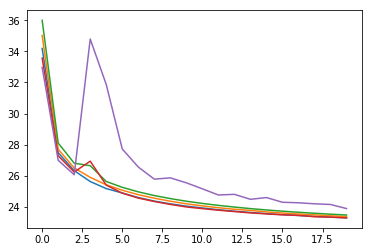

In [30]:
import math
import matplotlib.pyplot as plt
l = []
for x in list_of_files:
    with open("models/SGD/test/" + x, 'rb') as output:
            dict_emb = pickle.load(output)
    if (x!= "dict_emb_OptimSGD_momentum0_nesterovFalse_step_size1_gamma1_shuffleFalse_batch_size5000_alpha30_dim100_workers1_ctxw5_neg_samples10_use_cudaTrue_iterations20.pkl"):
        l.append([x/ 1000 for x in dict_emb['loss_list']])
    
for x in l:
    plt.plot(x)
plt.show

AttributeError: 'Figure' object has no attribute 'xticks'

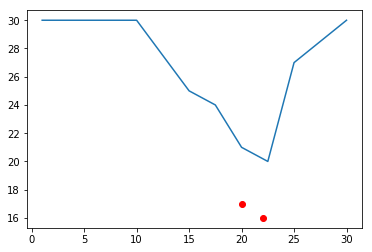

In [86]:
import matplotlib.pyplot as plt
tr_time_sgd = [30,30,30,25,24,21,20,27,30]
lr_sgd      = [1,5,10,15,17.5,20,22.5,25,30]
tr_time_adam = [30,25,27,30,30,30,30]
lr_adam = [0.00025,0.0005,.00075,.001,.0025,0.005,0.1]
assert( len(lr_sgd) == len(tr_time_sgd))
fig = plt.figure()
sgd = fig.add_subplot(111)
#adam = fig.add_subplot(252)
sgd.plot(lr_sgd,tr_time_sgd)
#adam.plot(lr_adam,tr_time_adam)
sgd.plot(20,17,'ro')
sgd.plot(22,16, 'ro')
#fig.xscale('log', basex=2)
fig.xticks([0.0001,0.001,0.01,0.1,1,10,100])
plt.show()

In [8]:

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.plotly as py
import plotly.graph_objs as go


learning_rates = [5e-05, 0.0001,0.00025,0.0005,.00075,.001,0.002,.0025,0.005,0.0075,.01,.025,.05,0.075,0.1,0.25,0.5] + [1,1.5,2,2.5,3,4,5,7.5,10,15,17.5,20,22.5,25,30,32.5,35,40,45,50]
lr_dict = {x: i for i,x in enumerate(learning_rates)}
# SGD
lr_sgd      = [0.00025,0.0005,0.00075,0.001,0.0025,0.005,0.0075,0.01,0.025,0.05]
tr_time_sgd = [20,20,20,20,20,16,6,20,20,20]
lr_sgd_dict = [lr_dict[x] for x in lr_sgd]
assert(len(lr_sgd)== len(tr_time_sgd))
# ADAM
lr_adam = [0.00005,0.0001,0.0005,0.001,0.005,0.05,0.1,0.5,1,1.5,2,3,4]
lr_adam_dict = [lr_dict[x] for x in lr_adam]
tr_time_adam = [10,9,10,5,5,5,5,12,11,10,9,10,12]
# adagrad
lr_adagrad = [0.00075,0.001,0.05,0.075,0.1,0.25,0.5,1,5]
lr_adagrad_dict = [lr_dict[x] for x in lr_adagrad]
tr_time_adagrad = [20,20,16,13,4,6,11,20,20]
# momentum
lr_mom = [0.0001,0.00025,0.0005,0.00075,0.001,0.002,0.0025,0.005] 
lr_mom_dict = [lr_dict[x] for x in lr_mom]
tr_time_mom = [20,20,13,11,9,20,20,20]
# NAG
lr_nag = [0.00025,0.0005,0.00075,0.001,0.0025,0.005]
lr_nag_dict = [lr_dict[x] for x in lr_nag]
tr_time_nag = [20,15,12,12,20,20]

trace1 = go.Scatter(
    x=lr_sgd_dict,
    y=tr_time_sgd,
    mode='lines+markers',
    name="sgd",
    hoverinfo='name',
    line=dict(
        shape='linear',color='rgb(20,125,190)'
    )
)
trace2 = go.Scatter(
    x= lr_adam_dict,
    y=tr_time_adam,
    mode='lines+markers',
    name="adam",
    hoverinfo='text+name',
    line=dict(
        shape='linear',color='rgb(245,145,30)'
        
    )
)
trace3 = go.Scatter(
    x= lr_adagrad_dict,
    y=tr_time_adagrad,
    mode='lines+markers',
    name="adagrad",
    hoverinfo='text+name',
    line=dict(
        shape='linear',color='rgb(25,160,75)'
    )
)
trace4 = go.Scatter(
    x= lr_mom_dict,
    y=tr_time_mom,
    mode='lines+markers',
    name="momentum",
    hoverinfo='text+name',
    line=dict(
        shape='linear',color='rgb(200,30,135)'
    )
)
trace5 = go.Scatter(
    x= lr_nag_dict,
    y=tr_time_nag,
    mode='lines+markers',
    name="nag",
    hoverinfo='text+name',
    line=dict(
        shape='linear',color='rgb(0,0,0)'
    )
)


data = [trace1,trace2,trace3,trace4,trace5]
layout = dict(title = 'Time to train vs. learning rate, by optimizer',
                 width = 800,
    height = 500,
    xaxis = dict(
        tickvals = list(lr_dict.values()),
        ticktext = list(lr_dict.keys()),
      title = "Learning rate"
    ),
    yaxis=dict(
        type='linear',
        title = 'Training time in number of Epochs',
        tickvals= [1,2,3,4,5,10,20],
        autorange=True
    )
              )

print(layout["xaxis"]["tickvals"])
fig = dict(data=data, layout=layout)
init_notebook_mode(connected=True)
iplot(fig, filename='word-embedding-plot.html')


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [28]:

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.plotly as py
import plotly.graph_objs as go

#learning_rates = [0.00025,0.0005,.00075,.001,0.1,0.25,0.5] + [2.5,5,7.5,10,15,20,22.5]
#lr_dict = {x: i for i,x in enumerate(learning_rates)}
# sgd_shuffle
lr_sgd_shuffle    = [0.00025,0.0005,0.00075,0.001,0.0025,0.005,0.0075,0.01,0.025,0.05,0.075,0.1]
tr_time_sgd_shuffle = [20,20,20,20,20,19,11,11,11,7,20,20]
lr_sgd_shuffle_dict = [lr_dict[x] for x in lr_sgd_shuffle]
assert len(lr_sgd_shuffle) == len(tr_time_sgd_shuffle)

# adam_shuffle
lr_adam_shuffle = [0.00005,0.0001,0.0005,0.001,0.005,0.05,0.1,0.5,1,1.5,2,3,4,5,7.5,10,15]
lr_adam_shuffle_dict = [lr_dict[x] for x in lr_adam_shuffle]
tr_time_adam_shuffle = [5,4,6,6,4,5,6,5,6,6,5,7,7,5,7,5,6]
assert len(lr_adam_shuffle) == len(tr_time_adam_shuffle), (str(len(lr_adam_shuffle))+ " "+ str(len(tr_time_adam_shuffle)))

# adagrad_shuffle
lr_adagrad_shuffle = [0.00075,0.001,0.05,0.075,0.1,0.25,0.5,1,2,5]
lr_adagrad_shuffle_dict = [lr_dict[x] for x in lr_adagrad_shuffle]
tr_time_adagrad_shuffle = [20,20,13,7,2,5,6,10,14,20]
assert len(lr_adagrad_shuffle) == len(tr_time_adagrad_shuffle), (str(len(lr_adagrad_shuffle))+ " "+ str(len(tr_time_adagrad_shuffle)))


# mom_suffleentum
lr_mom_suffle = [0.0005,0.00075,0.002,0.0025,0.05] 
lr_mom_suffle_dict = [lr_dict[x] for x in lr_mom_suffle]
tr_time_mom_suffle = [17,12,8,9,20]
assert len(lr_mom_suffle) == len(tr_time_mom_suffle), (str(len(lr_mom_suffle))+ " "+ str(len(tr_time_mom_suffle)))


# nag_shuffle
lr_nag_shuffle = [0.00025,0.0005,0.00075,0.001,0.0025,0.005,0.05]
lr_nag_shuffle_dict = [lr_dict[x] for x in lr_nag_shuffle]
tr_time_nag_shuffle = [20,19,9,9,7,6,20]
assert len(lr_nag_shuffle) == len(tr_time_nag_shuffle),(str(len(lr_nag_shuffle))+ " "+ str(len(tr_time_nag_shuffle)))




trace1a = go.Scatter(
    x=lr_sgd_shuffle_dict,
    y=tr_time_sgd_shuffle,
    mode='lines+markers',
    name="sgd_shuffle",
    hoverinfo='name',
    line=dict(
        shape='linear',dash='dot',color='rgb(20,125,190)'
    )
)
trace2a = go.Scatter(
    x= lr_adam_shuffle_dict,
    y=tr_time_adam_shuffle,
    mode='lines+markers',
    name="adam_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(245,145,30)'
        
    )
)
trace3a = go.Scatter(
    x= lr_adagrad_shuffle_dict,
    y=tr_time_adagrad_shuffle,
    mode='lines+markers',
    name="adagrad_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(25,160,75)'
    )
)
trace4a = go.Scatter(
    x= lr_mom_suffle_dict,
    y=tr_time_mom_suffle,
    mode='lines+markers',
    name="momentum_suffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(200,30,135)'
    )
)
trace5a = go.Scatter(
    x= lr_nag_shuffle_dict,
    y=tr_time_nag_shuffle,
    mode='lines+markers',
    name="nag_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(0,0,0)'
    )
)
data_a = [trace1a,trace2a,trace3a,trace4a,trace5a] 
data = data + data_a
layout = dict(title = 'Time to train vs. learning rate, by optimizer',
                 width = 800,
    height = 500,
    xaxis = dict(
        tickvals = list(lr_dict.values()),
        ticktext = list(lr_dict.keys()),
      title = "Learning rate"
    ),
    yaxis=dict(
        type='linear',
        title = 'Training time in number of Epochs',
        autorange=True
    )
              )

fig = dict(data=data, layout=layout)
fig1 = dict(data=data_a, layout=layout)
init_notebook_mode(connected=True)
#iplot(fig, filename='word-embedding-plot')
iplot(fig1, filename='word-embedding-plot')



In [31]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.plotly as py
import plotly.graph_objs as go
gensim_conv = [0,0.47 ,0.59,0.63,0.637,0.649, 0.64991,0.653,0.664,0.6655,0.6615,0.6629,0.663] 
adam_conv = [0,0.4796831063 ,0.5862162636,0.6298946727,0.648326564,0.6663352711,0.6692290085, 0.6709985856, 0.6687059277, 0.6676404941]
adagrad_conv = [0,0.6589294722,0.6741820076,0.6718779453,0.6689097502]
adagrad_shuffle_conv = [0,0.6646210026,0.6818005927,0.6784043309,0.6762544168]
sgd_conv = [0,0.2656567075,0.409453666,0.4961671944,0.5470711378,0.58201276,0.608320445,0.6224159501,0.6369093127,0.6457120334,0.653658488,0.6585042924,0.6608316399]
sgd_shuffle_conv = [0,0.3979027932,0.5345590809,0.5957749206,0.6150409906,0.6343477449,0.6408864911,0.6569273384,0.6638613219,0.664644281,0.6684268463,0.6676506492]

epoches = list(range(20))
trace1 = go.Scatter(
    x=epoches,
    y=gensim_conv,
    mode='lines+markers',
    name="gensim",
    hoverinfo='name',
    line=dict(
        shape='linear',color='rgb(139,0,0)'
    )
)
trace2 = go.Scatter(
    x= epoches,
    y=sgd_shuffle_conv,
    mode='lines+markers',
    name="SGD_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(20,125,190)'
        
    )
)
trace3 = go.Scatter(
    x=epoches,
    y=sgd_conv,
    mode='lines+markers',
    name="gensim",
    hoverinfo='name',
    line=dict(
        shape='linear',color='rgb(20,125,190)'
    )
)
trace4 = go.Scatter(
    x= epoches,
    y=adagrad_shuffle_conv,
    mode='lines+markers',
    name="adagrad_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',dash='dot',color='rgb(25,160,75)'
        
    )
)
trace5 = go.Scatter(
    x= epoches,
    y=adagrad_conv,
    mode='lines+markers',
    name="adagrad_shuffle",
    hoverinfo='text+name',
    line=dict(
        shape='linear',color='rgb(25,160,75)'
        
    )
)

data = [trace1,trace2,trace3,trace4,trace5]
layout = dict(title = 'Convergence time comparison',
                 width = 800,
    height = 500,
    xaxis = dict(
      title = 'Training time in number of Epochs'
    ),
    yaxis=dict(
        type='linear',
        title = "Word similarity",
             autorange=True
    )
              )

fig = dict(data=data, layout=layout)
init_notebook_mode(connected=True)
iplot(fig, filename='word-embedding-plot.html')
